# Intermediate Plotting

**Prerequisites**

- [Introduction](intro.ipynb)  


**Outcomes**

- Be able to build visualizations with multiple subplots  
- Add plot elements using data from multiple DataFrames  
- Understand the relationship between the matplotlib Figure and Axes
  objects  
- Customize fonts, legends, axis labels, tick labels, titles, and more!  
- Save figures to files to add to presentation, email, or use outside
  of a Jupyter notebook  


**Data**

- iPhone announcement dates  
- Apple stock price  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.transforms as transforms
import quandl

quandl.ApiConfig.api_key = os.environ.get("QUANDL_AUTH", "Dn6BtVoBhzuKTuyo6hbp")


%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Outline

- [Intermediate Plotting](#Intermediate-Plotting)  
  - [Introduction](#Introduction)  
  - [The Want Operator: Replicate a Professional Figure](#The-Want-Operator:-Replicate-a-Professional-Figure)  
  - [Data](#Data)  
  - [Warmup](#Warmup)  
  - [Data Cleaning](#Data-Cleaning)  
  - [Constructing the Plot](#Constructing-the-Plot)  
  - [Saving the Figure](#Saving-the-Figure)  
  - [Exercises](#Exercises)  

## Introduction

We have already seen a few examples of basic visualizations created
using the `.plot` method for a DataFrame.

When we use the `.plot` method, pandas uses a package called
matplotlib that actually creates the visualization.

In this lecture, we will dive deeper into the customization options in
the DataFrame `.plot` method as well as look under the hood at how to
use matplotlib directly to unlock unlimited control over our figures.

## The Want Operator: Replicate a Professional Figure

Visualization is a complex subject.

[Many
books](https://www.amazon.com/s/ref=nb_sb_noss?url=search-alias%3Dstripbooks&field-keywords=data+visualization&rh=n%3A283155%2Ck%3Adata+visualization)
have been written on the subject.

We cannot hope to convey all of what is possible in a short lecture, so
we thought we’d try something fun instead.

Our goal in this lecture is to show off some of the common – and some
not-so-common – matplotlib capabilities to try to re-create this
striking figure from a Financial Times
[article](https://www.ft.com/content/4743ce96-e4bf-11e7-97e2-916d4fbac0da).

The figure shows how we can see the anticipation of and response to iPhone
announcements in Apple stock share prices.

<img src="https://datascience.quantecon.org/assets/_static/matplotlib_files/aapl_iphone_announcments.png" alt="aapl\_iphone\_announcments.png" style="">

  
Our goal is to replicate the top portion of this figure in this lecture.

**Disclaimer**: Many tools you will see in this lecture will be
“more advanced” than what you typically use when customizing a plot.
Don’t (please!) try to memorize the commands used here – the purpose of
the lecture is to show what is possible and expose you a variety of the
methods you can use.

## Data

Let’s get the data.

First, we create a Series containing the date of each iPhone
announcement that appears in the FT original chart.

As there have only been 11 of them and we couldn’t find this “dataset”
online anywhere, we will do this by hand.

In [3]:
announcement_dates = pd.Series(
    [
        "First iPhone", "3G", "3GS", "4", "4S", "5", "5S/5C", "6/6 Plus",
        "6S/6S Plus", "7/7 Plus", "8/8 Plus/X"
    ],
    index=pd.to_datetime([
        "Jan. 9, 2007", "Jun. 9, 2008", "Jun. 8, 2009", "Jan. 11, 2011",
        "Oct. 4, 2011", "Sep. 12, 2012", "Sep. 10, 2013", "Sep. 9, 2014",
        "Sep. 9, 2015", "Sep. 7, 2016", "Sep. 12, 2017"
    ]),
    name="Model"
)
announcement_dates

2007-01-09    First iPhone
2008-06-09              3G
2009-06-08             3GS
2011-01-11               4
2011-10-04              4S
2012-09-12               5
2013-09-10           5S/5C
2014-09-09        6/6 Plus
2015-09-09      6S/6S Plus
2016-09-07        7/7 Plus
2017-09-12      8/8 Plus/X
Name: Model, dtype: object

Then, let’s grab Apple’s stock price data from quandl, starting a few
weeks before the first announcement.

In [4]:
aapl = quandl.get("WIKI/AAPL", start_date="2006-12-25")
aapl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2006-12-26,82.15,82.57,80.89,81.51,17524600.0,0.0,1.0,10.557420,10.611396,10.395492,10.475171,122672200.0
2006-12-27,78.15,82.00,76.77,81.52,69134100.0,0.0,1.0,10.043364,10.538143,9.866015,10.476456,483938700.0
2006-12-28,80.22,81.25,79.65,80.87,39995600.0,0.0,1.0,10.309388,10.441757,10.236135,10.392922,279969200.0
2006-12-29,83.95,85.40,83.36,84.84,38443900.0,0.0,1.0,10.788745,10.975090,10.712922,10.903122,269107300.0
2007-01-03,86.29,86.58,81.90,83.80,44225700.0,0.0,1.0,11.089468,11.126737,10.525291,10.769468,309579900.0


## Warmup

Matplotlib figures are composed two main types of Python objects:

1. `Figure`: represents the entirety of the visualization  
1. `Axes`: A (potentially full) subset of the figure on which things
  are drawn  


Most of the time, we will customize our plots by calling methods on an
Axes object.

However, things like setting a title over the entire plot or saving the
plot to a file on your computer require methods on a `Figure`.

Let’s start by getting our hands dirty and practicing using these
objects.


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)


You should have seen that the object returned by the `.plot` method is
a matplotlib Axes.

As mentioned above, we can control most aspects of a plot by calling
methods on an Axes.

Let’s see some examples.

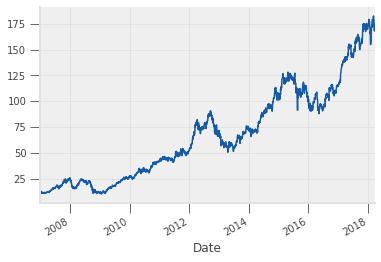

In [5]:
# plot the Adjusted open to account for stock split
ax = aapl["Adj. Open"].plot()

# get the figure so we can re-display the plot after making changes
fig = ax.get_figure()

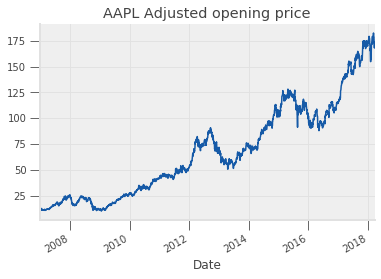

In [6]:
# set the title
ax.set_title("AAPL Adjusted opening price")

fig

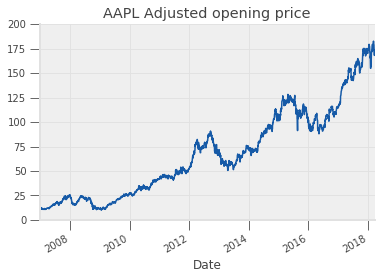

In [7]:
ax.set_ylim(0, 200)
fig

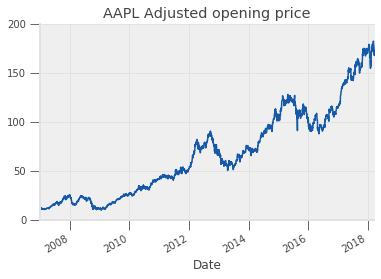

In [8]:
ax.set_yticks([0, 50, 100, 150, 200])
fig

We can also create a Figure and Axes beforehand and then tell pandas to
plot a DataFrame or Series’ data on the axis.

We typically use the `plt.subplots` function to create the Figure and
Axes.

Below, we use this function to create a Figure that is 10 inches wide by
6 inches tall and filled with a one by two grid of Axes objects.

type(fig2):  <class 'matplotlib.figure.Figure'>
type(axs):  <class 'numpy.ndarray'>
axs2.shape:  (2,)


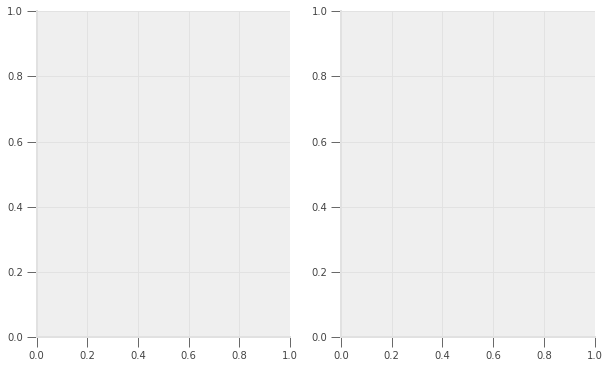

In [9]:
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 6))

print("type(fig2): ", type(fig2))
print("type(axs): ", type(axs2))
print("axs2.shape: ", axs2.shape)

We can plot from our DataFrame directly on our Axes objects by setting
the `ax` argument when calling `.plot`.

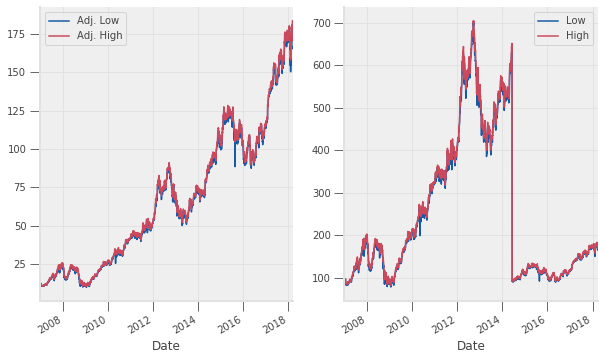

In [10]:
aapl[["Adj. Low", "Adj. High"]].plot(ax=axs2[0])
aapl[["Low", "High"]].plot(ax=axs2[1])
fig2


<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)



<a id='exercise-2'></a>
> See exercise 3 in the [*exercise list*](#exerciselist-0)

## Data Cleaning

Let’s continue on our path to recreating the Financial Times
visualization from above.

Before we can actually make the plot, we first have to clean the data.

Looking at our goal, we will need share price three days before and
after each announcement.

We will also need to normalize the share price to be 100 on the day of
the announcement and scale the neighboring days accordingly.

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

bday_us = CustomBusinessDay(calendar=USFederalHolidayCalendar())

def neighbor_dates(date, nbefore=3, nafter=3):
    # Make sure the date is a datetime
    date = pd.to_datetime(date)

    # Create a list of business days
    before_and_after = [date + i*bday_us for i in range(-nbefore, nafter+1)]

    return before_and_after


dates = []
for ann_date in announcement_dates.index:
    dates.extend(neighbor_dates(ann_date))
dates = pd.Series(dates)

# Index into our DataFrame using the new dates
prices = aapl.loc[dates]
prices.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2007-01-04,84.05,85.95,83.82,85.66,30259300.0,0.0,1.0,10.801596,11.045773,10.772038,11.008504,211815100.0
2007-01-05,85.77,86.20,84.40,85.05,29812200.0,0.0,1.0,11.022640,11.077901,10.846576,10.930110,208685400.0
2007-01-08,85.96,86.53,85.28,85.47,28468100.0,0.0,1.0,11.047058,11.120311,10.959669,10.984086,199276700.0
2007-01-09,86.45,92.98,85.15,92.57,119617800.0,0.0,1.0,11.110030,11.949226,10.942962,11.896535,837324600.0
2007-01-10,94.75,97.80,93.45,97.00,105460000.0,0.0,1.0,12.176696,12.568663,12.009627,12.465852,738220000.0


We now want to bring information on iPhone models into the DataFrame.

We do this by:

- Joining on the announcement date. This will introduce a new column
  named `Model` which has a value in the announcement date but has 3
  `NaN` above and below each announcement date (a total of 66
  `NaN`)  
- Using the methods `ffill` and `bfill`, we can replace these
  `NaN`s with the corresponding model names.  
- `prices.ffill(limit=3)` will fill the three days *after* the
  announcement with the model name (down to 33 Nan)  
- `prices.bfill(limit=3)` will fill the three days *before* the
  announcement with the model name (no more `NaN`)  

In [12]:
prices = prices.join(announcement_dates)
print(prices["Model"].isnull().sum())
prices["Model"].head(7)

66


Date
2007-01-04             NaN
2007-01-05             NaN
2007-01-08             NaN
2007-01-09    First iPhone
2007-01-10             NaN
2007-01-11             NaN
2007-01-12             NaN
Name: Model, dtype: object

In [13]:
prices = prices.ffill(limit=3)
print(prices["Model"].isnull().sum())
prices["Model"].head(7)

33


Date
2007-01-04             NaN
2007-01-05             NaN
2007-01-08             NaN
2007-01-09    First iPhone
2007-01-10    First iPhone
2007-01-11    First iPhone
2007-01-12    First iPhone
Name: Model, dtype: object

In [14]:
prices = prices.bfill(limit=3)
print(prices["Model"].isnull().sum())
prices["Model"].head(7)

0


Date
2007-01-04    First iPhone
2007-01-05    First iPhone
2007-01-08    First iPhone
2007-01-09    First iPhone
2007-01-10    First iPhone
2007-01-11    First iPhone
2007-01-12    First iPhone
Name: Model, dtype: object

Success!

Now for the second part of the cleaning: normalize the share price on
each announcement date to 100 and scale all neighbors accordingly.

In [15]:
def scale_by_middle(df):
    # How many rows
    N = df.shape[0]

    # Divide by middle row and scale to 100
    # Note: N // 2 is modulus division meaning that it is
    #       rounded to nearest whole number)
    out = (df["Open"] / df.iloc[N // 2]["Open"]) * 100

    # We don't want to keep actual dates, but rather the number
    # of days before or after the announcment. Let's set that
    # as the index. Note the +1 because range excludes upper limit
    out.index = list(range(-(N//2), N//2+1))

    # also change the name of this series
    out.name = "DeltaDays"
    return out

In [16]:
to_plot = prices.groupby("Model").apply(scale_by_middle).T
to_plot

Model,3G,3GS,4,4S,5,5S/5C,6/6 Plus,6S/6S Plus,7/7 Plus,8/8 Plus/X,First iPhone
DeltaDays,,,,,,,,,,,
-3,99.502488,97.343902,97.053874,107.301706,101.679538,98.824575,99.767864,98.883615,98.432718,99.680216,97.223829
-2,100.719230,97.434293,96.842380,103.350509,102.039439,98.467009,99.717400,95.789381,99.879440,98.923805,99.213418
-1,101.665585,101.036017,98.245767,101.548442,99.739072,99.762940,100.222043,98.145218,100.064917,98.702417,99.433198
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,97.517846,99.993047,99.527372,98.208613,101.577566,92.258021,98.920065,96.932138,99.462116,98.314987,109.600925
2,99.686351,98.929217,100.081188,99.668954,103.464797,92.552351,101.342350,98.268284,97.041640,97.773815,110.977444
3,98.123513,97.031011,100.292855,100.323037,104.873660,92.718333,102.149778,102.478903,95.196142,97.454031,109.415847


Re-order the columns.

In [17]:
to_plot = to_plot[announcement_dates.values]
to_plot

Model,First iPhone,3G,3GS,4,4S,5,5S/5C,6/6 Plus,6S/6S Plus,7/7 Plus,8/8 Plus/X
DeltaDays,,,,,,,,,,,
-3,97.223829,99.502488,97.343902,97.053874,107.301706,101.679538,98.824575,99.767864,98.883615,98.432718,99.680216
-2,99.213418,100.719230,97.434293,96.842380,103.350509,102.039439,98.467009,99.717400,95.789381,99.879440,98.923805
-1,99.433198,101.665585,101.036017,98.245767,101.548442,99.739072,99.762940,100.222043,98.145218,100.064917,98.702417
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,109.600925,97.517846,99.993047,99.527372,98.208613,101.577566,92.258021,98.920065,96.932138,99.462116,98.314987
2,110.977444,99.686351,98.929217,100.081188,99.668954,103.464797,92.552351,101.342350,98.268284,97.041640,97.773815
3,109.415847,98.123513,97.031011,100.292855,100.323037,104.873660,92.718333,102.149778,102.478903,95.196142,97.454031


## Constructing the Plot

Now that we have cleaned up the data, let’s construct the plot.

We do this by using the DataFrame `.plot` method and then using the
matplotlib methods and functions to fine tune our plot, changing one
feature or set of features at a time.

To prepare our use of the plot method, we will need to set up some data
for what color each line should be, as well as where to draw the tick
marks on the vertical axis.

In [18]:
# colors
background = tuple(np.array([253, 238, 222]) / 255)
blue = tuple(np.array([20, 64, 134]) / 255)
pink = tuple(np.array([232, 75, 126]) / 255)

def get_color(x):
    if "S" in x:
        return pink
    else:
        return blue

colors = announcement_dates.map(get_color).values

# yticks
yticks = [90, 95, 100, 105, 110, 115]

Below, we construct the basic plot using `to_plot.plot`.

Notice that we have specified a few options as keyword arguments to our
function.

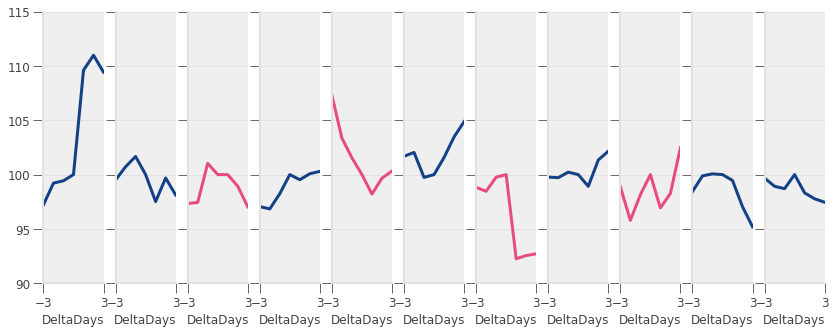

In [19]:
# construct figure and Axes objects
fig, axs = plt.subplots(1, 11, sharey=True, figsize=(14, 5))

# We can pass our array of Axes and `subplots=True`
# because we have one Axes per column
to_plot.plot(
    ax=axs, subplots=True, legend=False,
    yticks=yticks, xticks=[-3, 3],
    color=colors, linewidth=3, fontsize=12
);


<a id='exercise-3'></a>
> See exercise 4 in the [*exercise list*](#exerciselist-0)

### Subplot Spacing: `fig.tight_layout`

That figure has the basic lines we are after, but is quite ugly when
compared to the FT figure we are trying to produce.

Let’s refine the plot one step at a time.

First, notice how the `-3` and `3` labels are running into each
other?

This commonly happens in figures with many subplots.

The function `fig.tight_layout()` will fix these problems – as well
as most other subplot spacing issues.

We *almost always* call this method when building a plot with multiple
subplots.

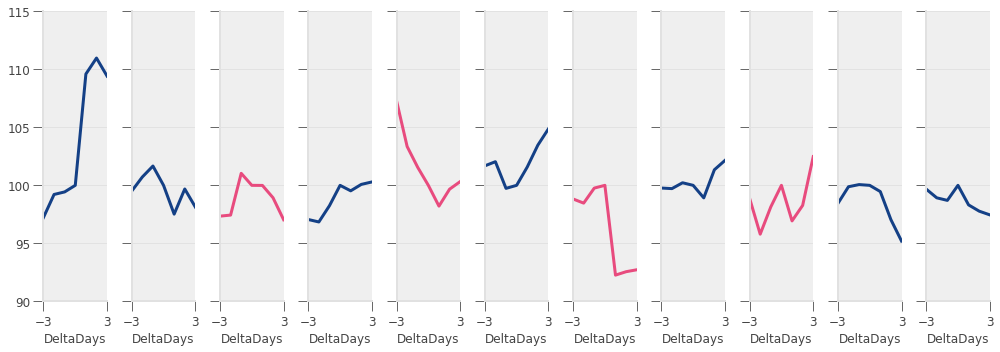

In [20]:
# add some spacing around subplots
fig.tight_layout()
fig

### Properties of the Figure

Now, let’s make the background of our figure match the background of the
FT post.

To do this, we will use the `fig.set_facecolor` method.

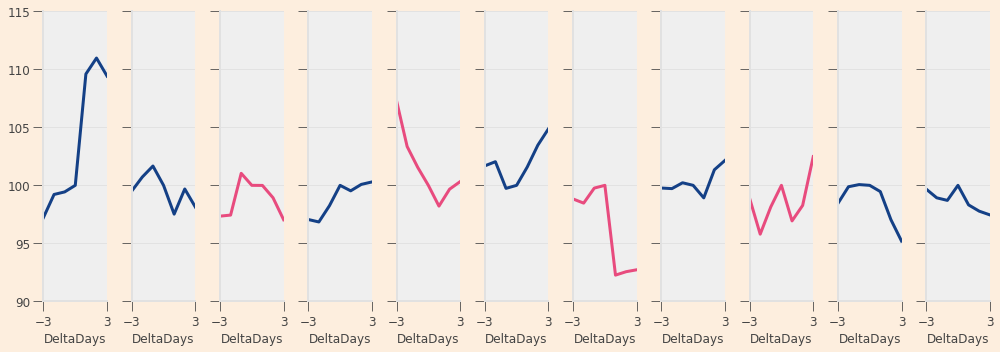

In [21]:
# set background color
fig.set_facecolor(background)
fig

### Properties of an `Axes`

Notice that this worked for the figure as a whole, but not for any of
the Axes.

To fix this, we will need to call `.set_facecolor` on each Axes.

While we are doing that, let’s fix up a number of other things about the
Axes:

- Add Axes titles  
- Remove the x axis titles  
- Remove tick marks on y axis  
- Add a “faint” version of the line from the first subplot  
- Remove x axis tick labels  
- Make x axis ticks longer and semi-transparent  
- Make sure all Axes have same y limits  
- Remove the spines (the border on each Axes)  
- Add a white circle to (0, 100) on each Axes  

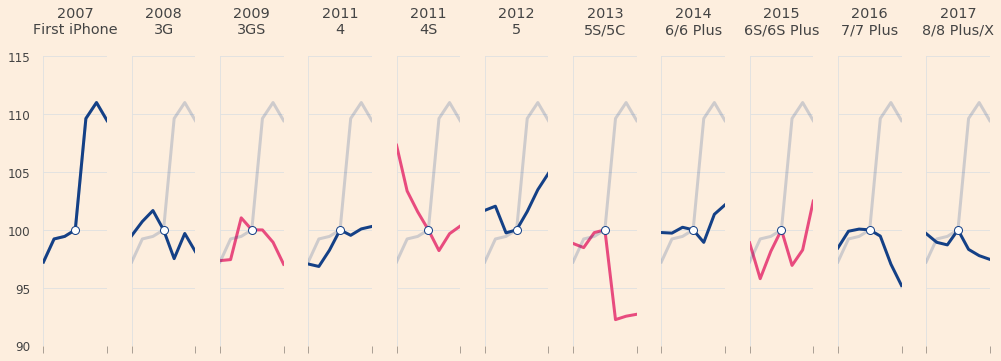

In [22]:
# For each Axes... do the following
for i in range(announcement_dates.shape[0]):
    ax = axs[i]

    # add faint blue line representing impact of original iPhone announcement
    to_plot["First iPhone"].plot(ax=ax, color=blue, alpha=0.2, linewidth=3)

    # add a title
    ti = str(announcement_dates.index[i].year) + "\n" + announcement_dates.iloc[i] + "\n"
    ax.set_title(ti)

    # set background color of plotting area
    ax.set_facecolor(background)

    # remove xlabels
    ax.set_xlabel("")

    # turn of tick marks
    ax.tick_params(which="both", left=False, labelbottom=False)

    # make x ticks longer and semi-transparent
    ax.tick_params(axis="x", length=7.0, color=(0, 0, 0, 0.4))

    # set limits on vertical axis
    ax.set_ylim((yticks[0], yticks[-1]))

    # add a white circle at 0, 100
    ax.plot(0, 100, 'o', markeredgecolor=blue, markersize=8, color="white", zorder=10)

    # remove border around each subplot
    for direction in ["top", "right", "left", "bottom"]:
        ax.spines[direction].set_visible(False)


fig


<a id='exercise-4'></a>
> See exercise 5 in the [*exercise list*](#exerciselist-0)


Let’s continue and add tick labels to the right of the far right
Axes.

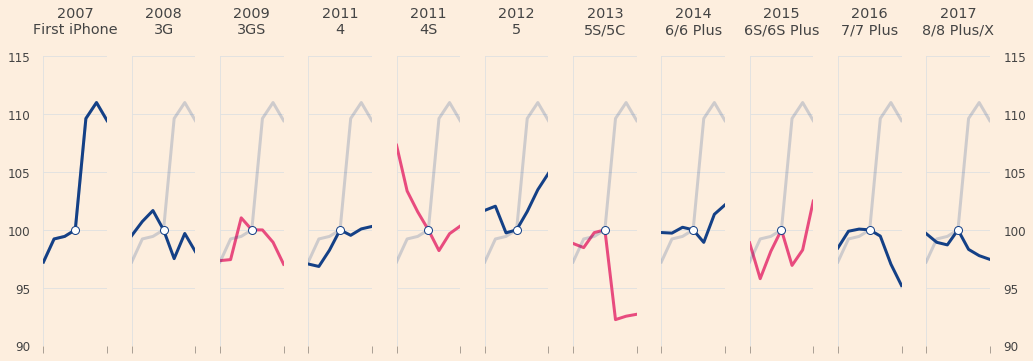

In [23]:
# add tick labels to right of iPhone 8/X announcement
axs[-1].tick_params(labelright=True, labelsize=12)
axs[-1]
fig

We can also add tick labels for the x-axis ticks on the 1st and 6th
plots.

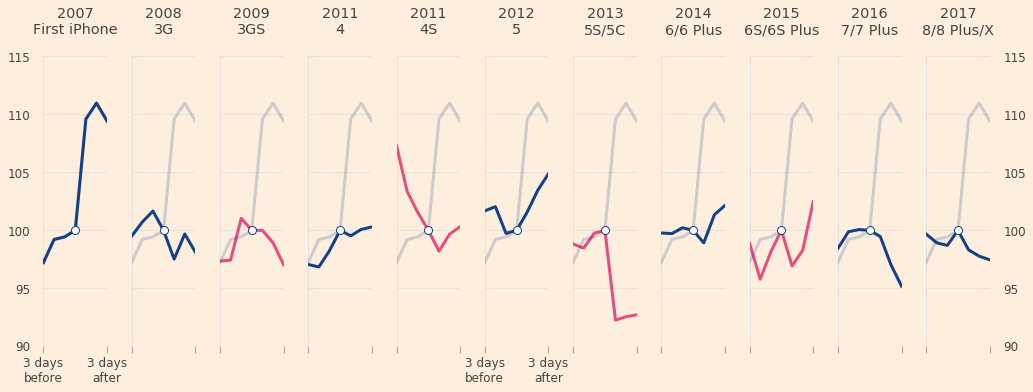

In [24]:
for ax in axs[[0, 5]]:
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(["3 days\nbefore", "3 days\nafter"])

    # need to make these tick labels centered at tick,
    # instead of the default of right aligned
    for label in ax.xaxis.get_ticklabels():
        label.set_horizontalalignment("center")

fig

### Transforms and Lines

Now we would like to add a horizontal line that lines up with each
vertical tick label (the numbers from 90 to 115) and runs across the
entire figure.

This is actually harder than it sounds because most of the “drawing”
capabilities of matplotlib are built around drawing on a single Axes and
we want to draw across 11 of them.

However, as we promised above, anything *is* possible and we will show
you how to do it.

When matplotlib draws any data – be it a line, circle, rectangle, or
other – it must know what *coordinate system* to use.

We typically think about drawing things in the *data’s* coordinate
system (remember above how we added a white circle at (0, 100)).

However, we might also want to draw using two other coordinate systems:

- Figure: the bottom left of the figure is (0, 0) and top right is (1,
  1)  
- Axes: The bottom left of an Axes is (0, 0) and top right is (1, 1)  


For our application, we would like to use the figure’s coordinate system
in the `x` dimension (going across the plot), but the data’s
coordinate system in the `y` dimension (so we make sure to put the
lines at each of our `yticks`).

Luckily for us, matplotlib provides a way to use *exactly* that coordinate
system.

In [25]:
# create a transform that...
trans = transforms.blended_transform_factory(
    fig.transFigure,  # goes across whole figure in x direction
    axs[0].transData  # goes up with the y data in the first axis
)

We can now use `trans` to draw lines where the `x` values will map
from (0, 1) in the Figure coordinates and the `y` values will go from
(90, 115) on the data coordinates.

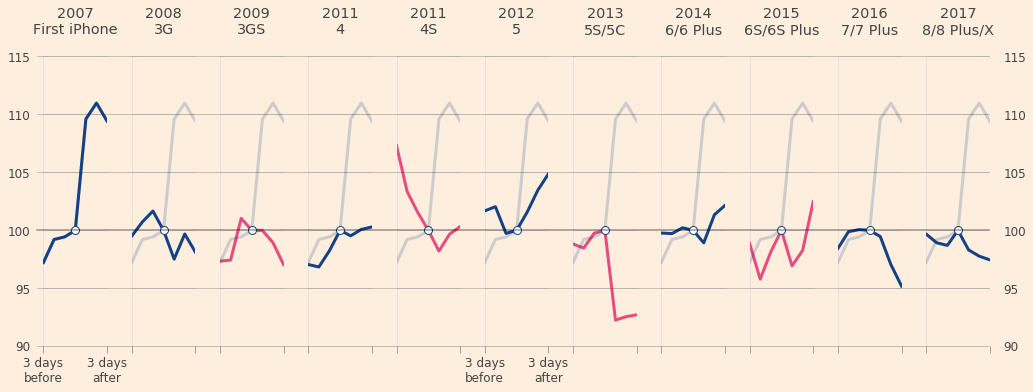

In [26]:
for y in yticks:
    l = plt.Line2D(
        # x values found by trial and error
        [0.04, 0.985], [y, y],
        transform=trans,
        color="black", alpha=0.4, linewidth=0.5,
        zorder=0.1
    )

    if y == 100:
        l.set_linewidth(1.5)

    fig.lines.append(l)

fig

Now, we need to a add vertical line from the (0, 90) to (0, 100) on the
first axis so we can label the center of each line as the announcement
date.

We will split this line in two to leave room for the text `Announced`
to be added soon.

To add the lines, we will use the data coordinate system from the first
Axes.

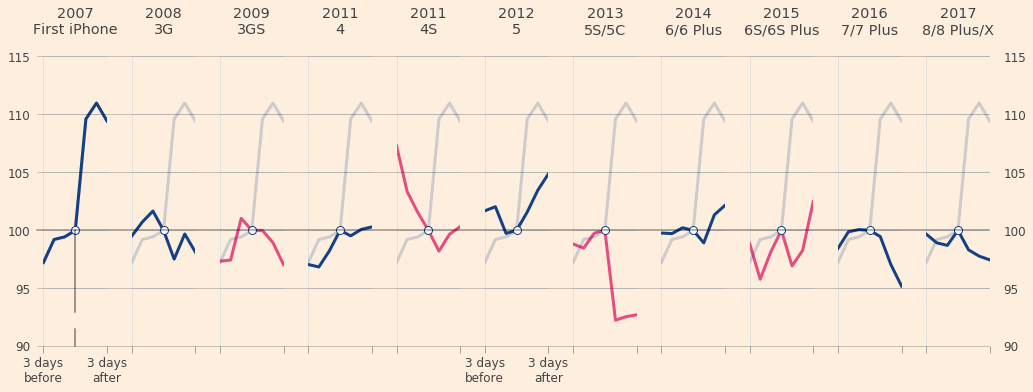

In [27]:
for y in ([90, 91.5], [93, 100]):
    l = plt.Line2D(
        [0, 0], y,
        transform=axs[0].transData,
        color="black", alpha=0.5, linewidth=1.5, zorder=0.1
    )

    fig.lines.append(l)
fig

### Annotations

The last step on our journey is to add annotations that mark Tim Cook’s
first announcement as CEO, the lackluster market response to `S` model
announcements, and a label showing that the white dot on each subplot is
associated with the announcement date.

Adding text to figures is always a bit verbose, so don’t get too scared
by what is happening here.

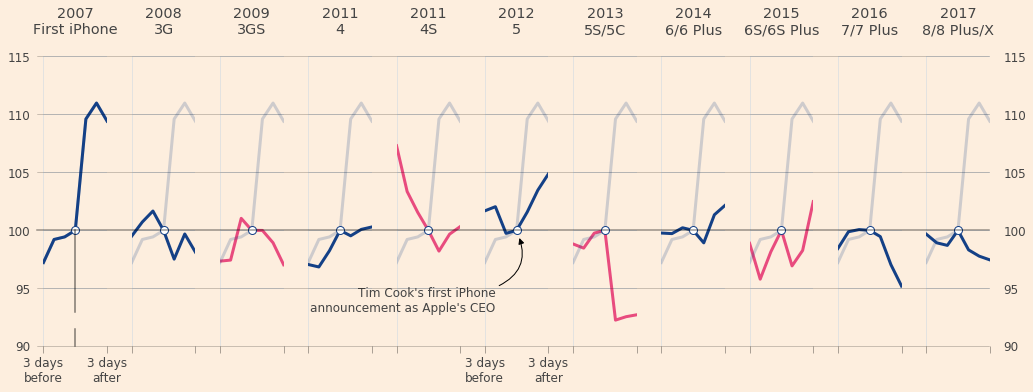

In [28]:
axs[5].annotate(
    "Tim Cook's first iPhone\nannouncement as Apple's CEO",
    xy=(0.2, 99.5), xycoords="data", xytext=(-2, 93),
    annotation_clip=False,
    horizontalalignment="right",
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=110",
        "color": "black"
    },
    fontsize=12,
)

fig

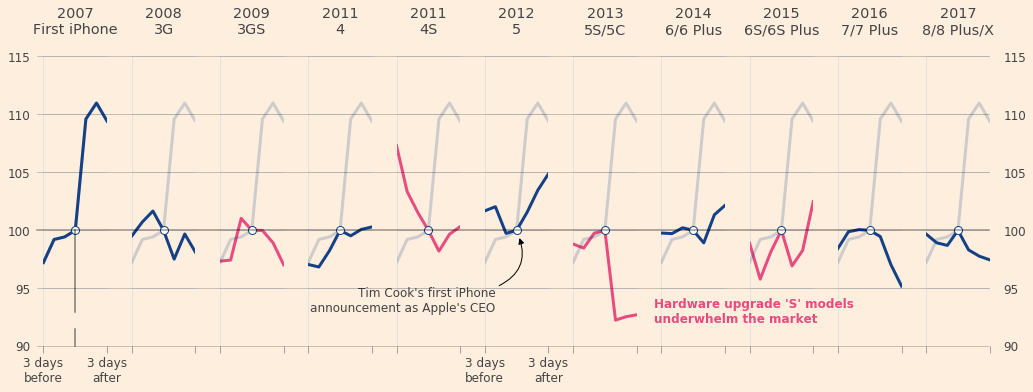

In [29]:
for ann in axs[8].texts:
    ann.remove()

axs[8].annotate(
    "Hardware upgrade 'S' models\nunderwhelm the market",
    xy=(-5, 99.5), xycoords="data", xytext=(-12, 92),
    annotation_clip=False,
    horizontalalignment="left",
    arrowprops={"visible": False},
    fontsize=12, fontweight="semibold",
    color=pink,
)
axs[8].set_zorder(0.05)
fig

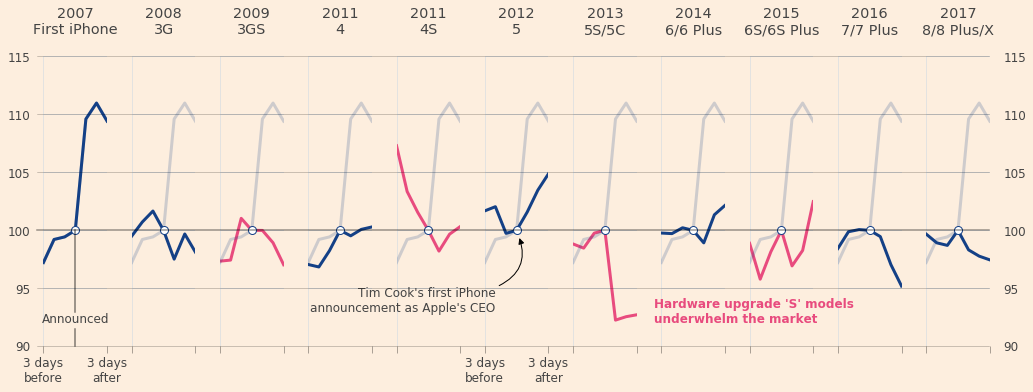

In [30]:
axs[0].annotate(
    "Announced",
    xy=(0, 99.5), xycoords="data", xytext=(0, 92),
    annotation_clip=False,
    horizontalalignment="center",
    arrowprops={"visible": False},
    fontsize=12,
)
fig

## Saving the Figure

Now that we have a finished product we are happy with, let’s save it to
a file on our computer using the `fig.savefig` function.

In [31]:
fig.savefig("aapl_iPhone_annoucements.png", dpi=400, bbox_inches="tight", facecolor=background)

Here, we asked matplotlib to save our figure in the `png` format, with
400 dots per inch (`dpi`, meaning each inch has a 400 by 400 set of
colored points).

The `bbox_inches` command is needed here to make sure pandas doesn’t
chop off any of our Axes titles or tick labels.

The `facecolor` argument was necessary because matplotlib
will save figures with a transparent background by default (meaning the background
is see-through so it “adopts” the background color of whatever website,
document, or presentation is is placed in).

We could have chosen a different file format.

In [32]:
fig.savefig("aapl_iPhone_annoucements.jpeg", dpi=400, bbox_inches="tight", facecolor=background)

# dpi not needed as pdf is a "vector" format that effectively has an infinite dpi
fig.savefig("aapl_iPhone_annoucements.pdf", bbox_inches="tight", facecolor=background)

# svg is also a vector format
fig.savefig("aapl_iPhone_annoucements.svg", bbox_inches="tight", facecolor=background)

### Summary

Phew, we made it!

We ended up writing quite a bit of code to get the figure to look
*exactly* how we wanted it to look.

Typically, our plotting code will be much more concise and simple
because we don’t usually require the same standards for aesthetic
properties as professional journalists do.

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

**Exercise:** Using the `.plot` method, plot the opening share price
for Apple's stock.

What `type` of object is returned from that method?

What methods does this object have?

In [33]:
# make plot here

In [34]:
# explore methods here

([*back to text*](#exercise-0))

**Exercise 2**

Using the `plt.subplots` function, make a Figure with a two-by-one
grid of subplots (two rows, one column).

On the upper Axes, plot the adjusted close price.

On the lower one, plot the adjusted volume as an area chart (search for
an argument on the `plot` method to change the kind of plot).

Google for how to set a title for a `Figure` object and then do so.

([*back to text*](#exercise-1))

**Exercise 3**

Take 5 minutes to explore the different arguments to the DataFrame `.plot`
method. Try to make a plot that is both good looking and interesting (
we know, those are subjective, but do your best!).

Some arguments you might consider exploring are:

- `sharex` or `sharey`  
- `style`  
- `grid`  
- `color`  
- `kind`  


Hint: You can browse the [official pandas plotting
documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html)
for inspiration.

([*back to text*](#exercise-2))

**Exercise 4**

Think about  what each of the argument we passed to `.plot` does.

For some you might be able to guess, for others you will need to look at
the documentation.

For your reference, record your findings in a markdown cell below.

Hint: Use `to_plot.plot?` to pull up the docs.

([*back to text*](#exercise-3))

**Exercise 5**

For each operation in the list below (copied from above), make a note
of which functions/methods were called to achieve the result.
Edit the markdown cell containing the list directly.

Note: This might seem redundant since the comments above give the answers,
but forcing yourself to write out the names of the functions will help
you remember them when you need them later on.

- Change background color  
- Add Axes titles  
- Remove the x axis titles  
- Remove tick marks on y axis  
- Add a "faint" version of the line from the first subplot  
- Remove x axis tick labels  
- Make x axis ticks longer and semi-transparent  
- Make sure all Axes have same y limits  
- Remove the spines (the border on each Axes)  
- Add a white circle to (0, 100) on each Axes  


([*back to text*](#exercise-4))